In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import HDBSCAN
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from loader_clone import create_loaders

loader, explore_loader = create_loaders()

filtered_movies = explore_loader.movies_df

2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456


In [94]:
titles = [
    "Interstellar (2014)",
    "The Martian (2015)",
    "Ad Astra (2019)",
    "Hercules (1997)",
    "Percy Jackson & the Olympians: The Lightning Thief (2010)",
    "Clash of the Titans (2010)",
    "Fire Island (2022)",
    "The Menu (2022)",
    "Madagascar (2005)",
    "Incredibles 2 (2018)",
    "Incredibles, The (2004)",
    "Wheelman (2017)",
    "Drive (2011)"
    
]


In [95]:
movies_subset = filtered_movies[filtered_movies["title"].isin(titles)].copy()
movies_subset_eucl = movies_subset.copy()
movies_subset

,movieId,title,genres,plot,year
829,1566,Hercules (1997),"Adventure, Animation, Children, Comedy, Musical",The son of Zeus and Hera is stripped of his im...,1997
3660,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy","While trying to lead a quiet suburban life, a ...",2004
4085,33615,Madagascar (2005),"Adventure, Animation, Children, Comedy",A group of animals who have spent all their li...,2005
5352,74530,Percy Jackson & the Olympians: The Lightning T...,"Adventure, Fantasy",A teenager discovers he&#x27;s the descendant ...,2010
5392,76175,Clash of the Titans (2010),"Action, Adventure, Drama, Fantasy","Perseus, a demigod and the son of Zeus, battle...",2010
5733,88129,Drive (2011),"Crime, Drama, Film-Noir, Thriller",A mysterious Hollywood action film stuntman ge...,2011
6483,109487,Interstellar (2014),"Sci-Fi, IMAX",When Earth becomes uninhabitable in the future...,2014
7026,134130,The Martian (2015),"Adventure, Drama, Sci-Fi",An astronaut becomes stranded on Mars after hi...,2015
8066,179415,Wheelman (2017),"Action, Thriller",A getaway driver for a bank robbery realizes h...,2017
8260,187541,Incredibles 2 (2018),"Action, Adventure, Animation, Children",The Incredibles family takes on a new mission ...,2018


In [96]:
model = SentenceTransformer("all-MiniLM-L6-v2")

genre_embeddings = model.encode(movies_subset["genres"].tolist())
plot_embeddings = model.encode(movies_subset["plot"].tolist())

In [97]:
genre_weight, plot_weight = 0.2, 0.8
combined = genre_weight * genre_embeddings + plot_weight * plot_embeddings

In [98]:
clusterer = HDBSCAN(min_cluster_size=3, metric="cosine")
labels = clusterer.fit_predict(combined)
movies_subset["cluster"] = labels

In [99]:
proj = umap.UMAP(
    n_neighbors=3,
    min_dist=0.5,
    metric="cosine",
    random_state=42
)
res = proj.fit_transform(combined)

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


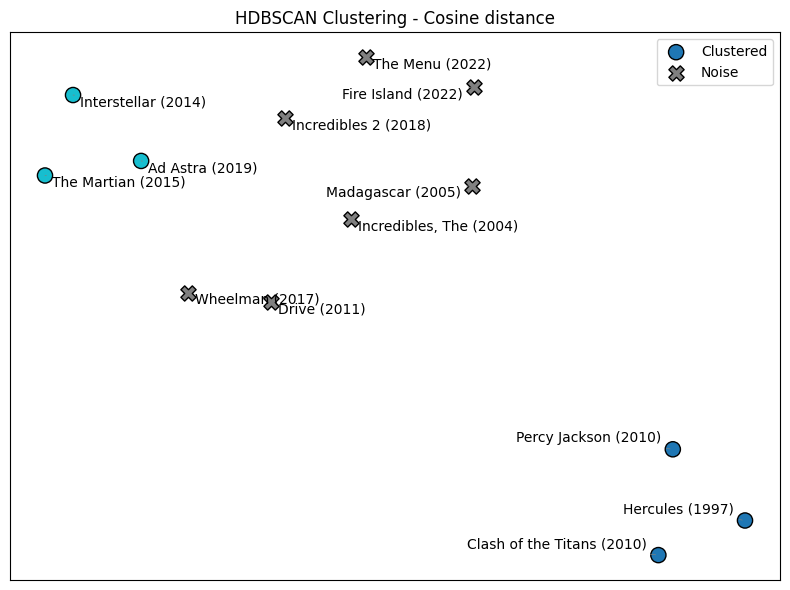

In [104]:
noise_mask = labels == -1
cluster_mask = labels != -1

plt.figure(figsize=(8, 6))

plt.scatter(
    res[cluster_mask, 0], res[cluster_mask, 1],
    c=labels[cluster_mask],
    cmap='tab10',
    s=120,
    edgecolor='k',
    label='Clustered'
)

plt.scatter(
    res[noise_mask, 0], res[noise_mask, 1],
    c='gray',
    s=120,
    edgecolor='k',
    marker='X',
    label='Noise'
)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

for i, full_title in enumerate(movies_subset["title"]):
    x, y = res[i, 0], res[i, 1]
    offset_x = -8 if x > (x_max + x_min) / 2 else 5
    offset_y = -8 if y > (y_max + y_min) / 2 else 5
    if "Percy Jackson" in full_title:
        year = full_title.split("(")[-1].rstrip(")")
        label = f"Percy Jackson ({year})"
    else:
        label = full_title
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(offset_x, offset_y),
        ha='left' if offset_x > 0 else 'right',
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        fontsize=10
    )

plt.title("HDBSCAN Clustering - Cosine distance")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()


In [105]:

clusterer_eucl = HDBSCAN(min_cluster_size=3, metric="euclidean")
labels_eucl = clusterer_eucl.fit_predict(combined)
movies_subset_eucl["cluster"] = labels_eucl

proj = umap.UMAP(
    n_neighbors=4,
    min_dist=0.8,
    metric="euclidean",
    random_state=42
)
res_eucl = proj.fit_transform(combined)

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


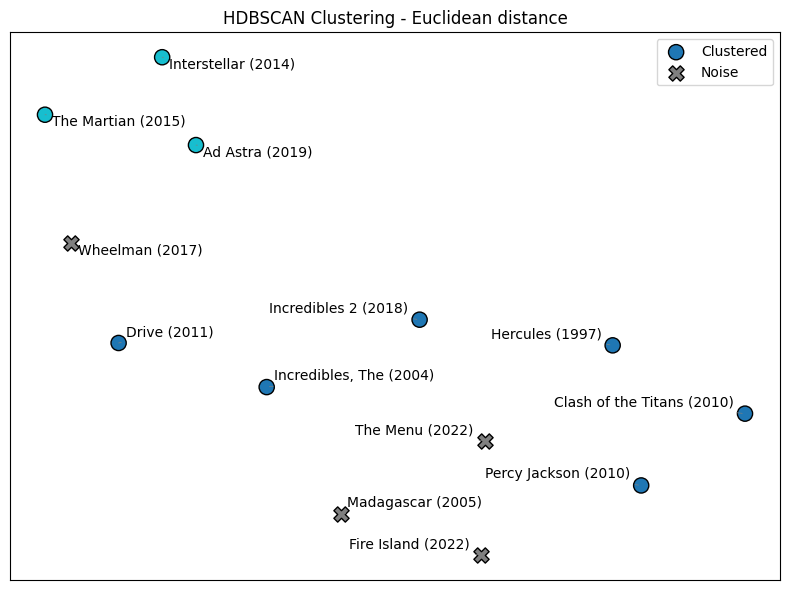

In [106]:
noise_mask = labels_eucl == -1
cluster_mask = labels_eucl != -1

plt.figure(figsize=(8, 6))

plt.scatter(
    res_eucl[cluster_mask, 0], res_eucl[cluster_mask, 1],
    c=labels_eucl[cluster_mask],
    cmap='tab10',
    s=120,
    edgecolor='k',
    label='Clustered'
)

plt.scatter(
    res_eucl[noise_mask, 0], res_eucl[noise_mask, 1],
    c='gray',
    s=120,
    edgecolor='k',
    marker='X',
    label='Noise'
)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

for i, full_title in enumerate(movies_subset_eucl["title"]):
    x, y = res_eucl[i, 0], res_eucl[i, 1]
    offset_x = -8 if x > (x_max + x_min) / 2 else 5
    offset_y = -8 if y > (y_max + y_min) / 2 else 5
    if "Percy Jackson" in full_title:
        year = full_title.split("(")[-1].rstrip(")")
        label = f"Percy Jackson ({year})"
    else:
        label = full_title
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(offset_x, offset_y),
        ha='left' if offset_x > 0 else 'right',
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        fontsize=10
    )

plt.title("HDBSCAN Clustering - Euclidean distance")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
